# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Jesus Ramirez Delgado
## Sistemas Multiagentes y Graficas Computacionales
## M1 Actividad

Para este problema, deberás entregar, de manera individual, un informe en PDF que estudie las estadísticas de un robot de limpieza reactivo, así como el enlace al repositorio en Github del código desarrollado para esta actividad. El código debe ajustarse al estilo solicita en el siguiente documento.

Dado:

Habitación de 20x20 espacios, no toroidal.
Número de agentes (1, 5, 10).
Porcentaje de celdas inicialmente sucias (80%).
Tiempo máximo de ejecución.
Realiza la siguiente simulación:

Inicializa las celdas sucias (ubicaciones aleatorias).
Todos los agentes empiezan en localidades aleatorios.
En cada paso de tiempo:
Si la celda está sucia, entonces aspira.
Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
Se ejecuta el tiempo máximo establecido.
Deberás recopilar la siguiente información durante la ejecución:

Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
Porcentaje de celdas limpias después de 500, 1000 y 1500 pasos de simulación.
¿Cuál es la cantidad mínima de agentes para lograr que el espacio esté limpio en menos de 1000 pasos?


In [55]:
import matplotlib
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import time
import datetime
import random

%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [56]:
class RobotAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)

    def step(self):
        this_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.model.is_dirty(self.pos):
            self.model.clean_cell(self.pos)
        else:
            possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            next_move = self.random.choice(possible_steps)
            self.model.grid.move_agent(self, next_move)

In [57]:
class RobotModel(Model):
    def __init__(self, width, height, initial_dirt, n_robots, max_steps=1500):
        super().__init__()
        self.num_agents = n_robots
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dirt_map = np.random.rand(width, height) < initial_dirt
        self.current_id = 0
        self.steps_taken = 0
        self.max_steps = max_steps

        for i in range(self.num_agents):
            robot = RobotAgent(self.next_id(), self)
            empty_cells = [(x, y) for x in range(width) for y in range(height) if self.grid.is_cell_empty((x, y))]
            if empty_cells:
                x, y = random.choice(empty_cells)
                self.grid.place_agent(robot, (x, y))
                self.schedule.add(robot)

        self.datacollector = DataCollector(
            model_reporters={
                "Clean Percentage": lambda m: np.sum(~m.dirt_map) / (m.grid.width * m.grid.height) * 100
            }
        )

    def is_dirty(self, pos):
        x, y = pos
        return self.dirt_map[x, y]

    def clean_cell(self, pos):
        x, y = pos
        self.dirt_map[x, y] = False

    def next_id(self):
        self.current_id += 1
        return self.current_id

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        self.steps_taken += 1
        if self.steps_taken == 500 or self.steps_taken == 1000 or self.steps_taken == 1500:
            print(f"Step {self.steps_taken}: {self.datacollector.get_model_vars_dataframe()['Clean Percentage'].iloc[-1]}% clean")
        if not np.any(self.dirt_map) or self.steps_taken >= self.max_steps:
            self.running = False
            print(f"Terminado en el paso: {self.steps_taken} con {self.datacollector.get_model_vars_dataframe()['Clean Percentage'].iloc[-1]}% limpio")


Step 500: 99.0% clean
Terminado en el paso: 570 con 100.0% limpio


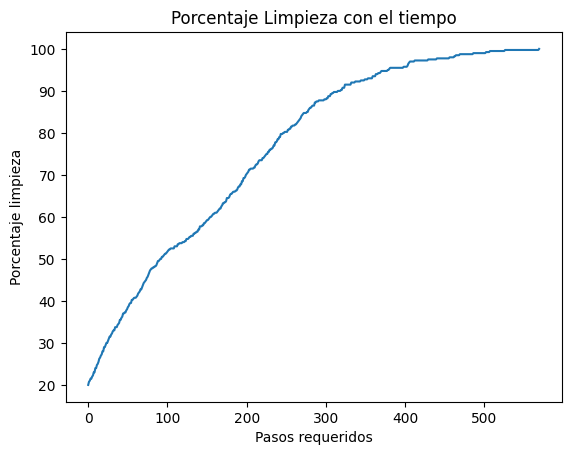

In [58]:
WIDTH = 20
HEIGHT = 20
INITIAL_DIRT = 0.8
ROBOTS = 5

model = RobotModel(WIDTH, HEIGHT, INITIAL_DIRT, ROBOTS)
while model.running:
    model.step()

# Graficar resultados
results = model.datacollector.get_model_vars_dataframe()
results['Clean Percentage'].plot()
plt.title('Porcentaje Limpieza con el tiempo')
plt.xlabel('Pasos requeridos')
plt.ylabel('Porcentaje limpieza')
plt.show()